<a href="https://colab.research.google.com/github/lukezhq10/fcc-neural-network-SMS-text-classifier/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-07-17 22:31:37--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.005s  

2023-07-17 22:31:37 (63.5 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-07-17 22:31:37--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

# Prepare data

In [ ]:
train_df = pd.read_csv(train_file_path, sep='\t', header=None, names=['type', 'msg'])
train_df.head()

,type,msg
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
train_df.shape

(4179, 2)

In [ ]:
train_df.isnull().sum()

type    0
msg     0
dtype: int64

In [ ]:
test_df = pd.read_csv(test_file_path, sep='\t', header=None, names=['type', 'msg'])
test_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
test_df.shape

(1392, 2)

In [ ]:
test_df.isnull().sum()

type    0
msg     0
dtype: int64

### Convert ham/spam data into numerical

In [ ]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [ ]:
train_df.head()

,type,msg
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...


## Prepare labels for training

In [ ]:
train_labels = train_df['type'].values
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['msg'].values, train_labels)
)

test_labels = test_df['type'].values
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['msg'].values, test_labels)
)
test_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

## Shuffling the data for training

In [ ]:
BUFFER_SIZE= 100
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Creating text encorder (TextVectorization layer)

In [ ]:
encoder = tf.keras.layers.TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000)

encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# First 20 tokens (vocab) the vectorizer has learned in order of frequency
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on'],
      dtype='<U15')

# Creating the model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1000)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1000, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

# Training the model

In [ ]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    validation_steps=30,
                    epochs=10)

Epoch 1/10
131/131 [==============================] - 441s 3s/step - loss: 0.6167 - accuracy: 0.8660 - val_loss: 0.4979 - val_accuracy: 0.8604
Epoch 2/10
131/131 [==============================] - 412s 3s/step - loss: 0.3551 - accuracy: 0.8696 - val_loss: 0.1809 - val_accuracy: 0.9167
Epoch 3/10
131/131 [==============================] - 409s 3s/step - loss: 0.1221 - accuracy: 0.9691 - val_loss: 0.0887 - val_accuracy: 0.9750
Epoch 4/10
131/131 [==============================] - 401s 3s/step - loss: 0.0770 - accuracy: 0.9816 - val_loss: 0.0713 - val_accuracy: 0.9844
Epoch 5/10
131/131 [==============================] - 402s 3s/step - loss: 0.0615 - accuracy: 0.9861 - val_loss: 0.0667 - val_accuracy: 0.9833
Epoch 6/10
131/131 [==============================] - 402s 3s/step - loss: 0.0494 - accuracy: 0.9883 - val_loss: 0.0589 - val_accuracy: 0.9865
Epoch 7/10
131/131 [==============================] - 402s 3s/step - loss: 0.0423 - accuracy: 0.9892 - val_loss: 0.0578 - val_accuracy: 0.9896

# Plotting the accuracy and loss metrics

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6463487481698393)

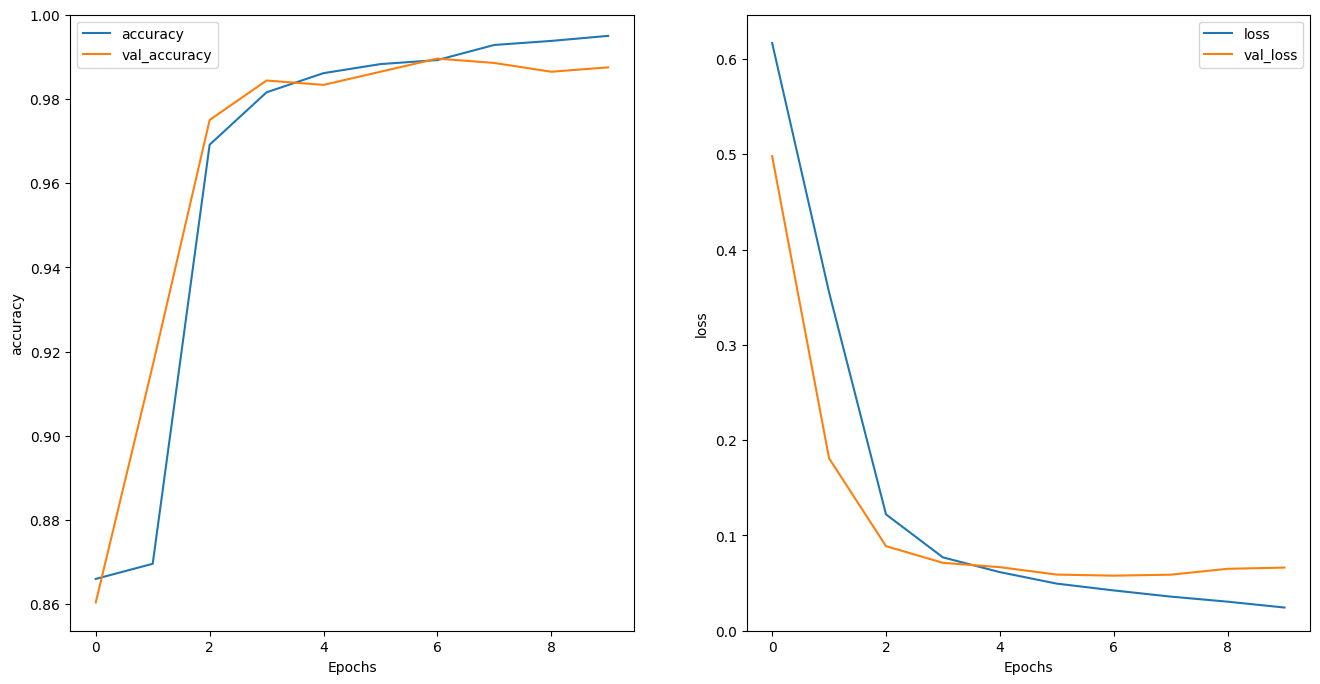

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# testing with a sample_text (expecting ham // prediction < 0.5)
sample_text = ('i am waiting machan. call me once you free.')
prediction = model.predict(np.array([sample_text]))
prediction

1/1 [==============================] - 5s 5s/step


array([[-7.8057895]], dtype=float32)

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  ps = model.predict([pred_text])
  print(ps)
  p = ps[0][0]
  return [p, 'ham' if p < 0.5 else 'spam']

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 246ms/step
[[-6.793994]]
[-6.793994, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 247ms/step
[[-6.793994]]
1/1 [==============================] - 0s 251ms/step
[[1.1497082]]
1/1 [==============================] - 0s 260ms/step
[[-9.482261]]
1/1 [==============================] - 0s 274ms/step
[[5.7597294]]
1/1 [==============================] - 0s 238ms/step
[[6.327782]]
1/1 [==============================] - 0s 252ms/step
[[-9.266316]]
1/1 [==============================] - 0s 256ms/step
[[-9.550528]]
You passed the challenge. Great job!
